In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Read in csv file then prepare the text to be processed by concatting all the comments in the dataframe as a single document where comments are separated by the newline character.

In [2]:
df = pd.read_csv('/Users/kevinmacmat/Documents/flatiron/module_projects/capstone/csv/comments_metadata.csv')

In [3]:
df.head(1)

,dbn,username,borough,grade_level,enrollment,comment,likes,dislikes,replies,post_date,...,pct_disabilities,pct_self_contained,economic_need_index,pct_temp_housing,pct_hra_eligible,pct_asian,pct_black,pct_hispanic,pct_white,pct_chronic_absent
0,01M015,P.S. 15 Parent,manhattan,Elementary,161,P.S. 15 is an extraordinary small school that ...,0,0,0,2020-05-11T14:13:41,...,0.23,0.006,0.889,0.398,0.77,0.124,0.28,0.553,0.037,0.227


In [4]:
text = df['comment'].str.cat(sep='\n')

Import Spacy's English Language pipeline and process the text and save as the "doc" variable.

In [5]:
from spacy.lang.en import English
nlp = spacy.load('en_core_web_md')
# Because of the size of the "text" we need to increase the max length. Before running, make sure
# your computer has enough free ram (rougly 1GB per 1,000,000 length).
nlp.max_length = 10000000

In [6]:
my_stop_words = [u'school', u'PS', u'read_<', u'teacher', u'child', u'parent', 
                 u'guardian', u'new', u'city', u'york', u'student', u'class',
                 u'like', u'great', u'know', u'go', u'kid', u'say', u'href="http://schools.nyc.gov_Offices',
                 u'\xa0 \n', u'\xa0\n', u'\xa0 ', u'<_/P', u'<_/p', u'n\n', u'son', u'daughter', u'u', u'ur']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [7]:
doc = nlp(text)

In [72]:
print(doc[373])
print(type(doc[373]))
print(type(doc[373].text))
print(doc[373].is_stop)
print(doc[373].lemma_)
doc[373].mem

Gem
<class 'spacy.tokens.token.Token'>
<class 'str'>
False
Gem


AttributeError: 'spacy.tokens.token.Token' object has no attribute 'mem'

In [8]:
# we add some words to the stop word list
texts, article = [], []
for word in doc:
    # if the word is not a stop word, punctuation, or number
    if word.text != '\n' and not word.is_stop and not word.is_punct and not word.like_num:
        # append lemmatized word to article container
        article.append(word.lemma_)
        # if newline then signals end of the document
    if word.text == '\n':
        texts.append(article)
        article = []

In [47]:
# first article, first 5 lemmatized words
texts[1][1]

'Gem'

In [10]:
article[0:10]

['locate', 'Bushwick', 'East', 'NY']

In [11]:
bigram = gensim.models.Phrases(texts)

In [12]:
texts = [bigram[line] for line in texts]

In [13]:
# looking at "texts" we can see the bigrams joined with an underscore
# texts

In [14]:
# create gensim.corpora.dictionary.Dictionary
dictionary = Dictionary(texts)
# create a corpus using bag of words
corpus = [dictionary.doc2bow(text) for text in texts]

In [15]:
# looking at "corpus" we can see a list of lists containing tuples for each word's index and count
# corpus

**LDA TOPIC MODEL**

In [16]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [17]:
ldamodel.show_topics()

[(0,
  '0.014*"principal" + 0.014*"Principal" + 0.009*"student" + 0.009*"Mrs" + 0.009*"hi" + 0.009*"scholar" + 0.008*"receive" + 0.008*"suck" + 0.007*"year" + 0.006*"say"'),
 (1,
  '0.120*">" + 0.029*"read_<" + 0.027*"school" + 0.023*"<_p" + 0.022*"<_/P" + 0.019*"student" + 0.018*"=" + 0.017*"<" + 0.012*"say" + 0.011*"report"'),
 (2,
  '0.043*"school" + 0.017*"I.S." + 0.011*"=_email&utm_campaign" + 0.011*"=_newsletter&utm_medium" + 0.010*"P.S." + 0.008*"School" + 0.007*"Department" + 0.007*"learn" + 0.006*"Regents" + 0.006*"improve"'),
 (3,
  '0.031*"teacher" + 0.025*"good" + 0.021*"student" + 0.020*"kid" + 0.013*"write" + 0.013*"go" + 0.012*"year" + 0.010*"say" + 0.010*"bad" + 0.008*"time"'),
 (4,
  '0.035*"program" + 0.016*"Staten_Island" + 0.015*"student" + 0.012*"art" + 0.011*"\n\n" + 0.008*"class" + 0.007*"offer" + 0.007*"parent" + 0.007*"child" + 0.006*"year"'),
 (5,
  '0.019*"Queens" + 0.010*"read" + 0.010*"cool" + 0.009*"ms" + 0.008*"garden" + 0.007*"throw" + 0.006*"book" + 0.0

**HDP TOPIC MODEL**

In [18]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [19]:
hdpmodel.show_topics()

[(0,
  '0.020*  + 0.016*teacher + 0.016*student + 0.009*   + 0.009*year + 0.009*kid + 0.008*parent + 0.008*child + 0.008*good + 0.006*principal + 0.006*school + 0.006*go + 0.005*program + 0.005*time + 0.005*work + 0.005*\n\n + 0.005*> + 0.004*learn + 0.004*need + 0.004*write'),
 (1,
  '0.018*  + 0.015*teacher + 0.015*student + 0.009*year + 0.008*   + 0.008*kid + 0.008*good + 0.008*parent + 0.007*child + 0.006*principal + 0.006*> + 0.006*school + 0.005*program + 0.005*go + 0.005*\n\n + 0.005*time + 0.004*staff + 0.004*work + 0.004*write + 0.004*say'),
 (2,
  '0.014*student + 0.014*  + 0.014*teacher + 0.009*> + 0.009*year + 0.007*good + 0.007*parent + 0.007*kid + 0.007*child + 0.007*school + 0.006*principal + 0.006*   + 0.005*go + 0.005*program + 0.004*time + 0.004*say + 0.004*write + 0.004*work + 0.004*learn + 0.004*help'),
 (3,
  '0.010*teacher + 0.009*student + 0.007*> + 0.007*  + 0.006*year + 0.005*good + 0.005*school + 0.004*parent + 0.004*child + 0.004*principal + 0.004*kid + 0.004

**LSI TOPIC MODEL**

In [20]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [21]:
lsimodel.show_topics(num_topics=5)

[(0,
  '0.647*" " + 0.301*"student" + 0.295*"teacher" + 0.201*"  " + 0.172*"year" + 0.155*"parent" + 0.151*"kid" + 0.145*"child" + 0.131*"good" + 0.111*"\n\n"'),
 (1,
  '-0.696*" " + 0.529*"  " + 0.240*"student" + 0.216*"teacher" + 0.101*"year" + 0.094*"kid" + 0.091*"\n\n" + 0.090*"good" + 0.067*"school" + 0.063*"go"'),
 (2,
  '-0.807*"  " + 0.359*"student" + -0.275*" " + 0.195*"teacher" + 0.123*"\n\n" + 0.077*"year" + 0.077*"good" + 0.069*"school" + 0.063*"kid" + 0.062*">"'),
 (3,
  '-0.775*"student" + 0.359*"kid" + 0.207*"teacher" + 0.199*"child" + 0.181*"parent" + 0.156*"good" + -0.131*"  " + 0.100*"year" + -0.093*" " + 0.091*"go"'),
 (4,
  '-0.666*"teacher" + 0.391*"child" + 0.338*"parent" + 0.268*"school" + 0.195*"\n\n" + 0.173*">" + -0.146*"good" + 0.101*"kid" + 0.094*"program" + 0.091*"middle"')]

**TOPIC COHERENCE** <br><br>
A coherence value is a way to compare topic models using a numerical value.

In [22]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [23]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [24]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width = 0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

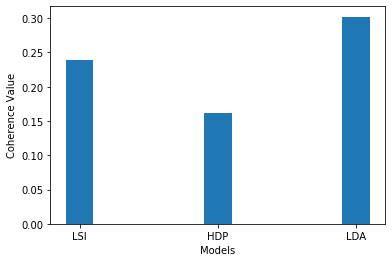

In [25]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence], ['LSI', 'HDP', 'LDA'])

**pyLDAvis**

In [26]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.221181 -0.028687       1        1  29.998053
7     -0.199785 -0.017130       2        1  26.193327
9     -0.174192 -0.020283       3        1  14.080848
4     -0.116363 -0.004758       4        1   9.467903
1      0.066599  0.287928       5        1   8.830596
6      0.093948  0.036606       6        1   2.820792
2      0.146973  0.021831       7        1   2.464734
5      0.055126 -0.129021       8        1   2.444197
0      0.075441 -0.037824       9        1   2.314029
8      0.273434 -0.108661      10        1   1.385523, topic_info=         Term          Freq         Total Category  logprob  loglift
179         >   7392.000000   7392.000000  Default  30.0000  30.0000
110            11917.000000  11917.000000  Default  29.0000  29.0000
522             5949.000000   5949.000000  Default  28.0000  28.0000
219    school   4946.000000   4946.000000  Default  27.0000  27.0000
245   program   4040.000000   4040.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
219    school     49.403587   4946.719727  Topic10  -5.2193  -0.3274
579   uniform     42.092804    313.023285  Topic10  -5.3795   2.2727
608  activity     42.853657    804.621094  Topic10  -5.3616   1.3465
533    middle     42.070683   1693.258667  Topic10  -5.3800   0.5840
29      child     38.162849   5874.738281  Topic10  -5.4775  -0.7575

[705 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1118      3  0.004664  \n\t_mso
1118      4  0.004664  \n\t_mso
1118      5  0.984164  \n\t_mso
376       1  0.307439      \n\n
376       2  0.177162      \n\n
...     ...       ...       ...
545       6  0.012408      \n\n
545       7  0.006204      \n\n
545       8  0.006204      \n\n
971       3  0.973105          
971       4  0.018714          

[2049 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 10, 5, 2, 7, 3, 6, 1, 9])